In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 200)
pd.set_option("display.float_format", "{:,.4f}".format)


In [37]:
df = pd.read_csv("train.csv")
df["date"] = pd.to_datetime(df["date"])

df.head()


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0000,0
1,1,2013-01-01,1,BABY CARE,0.0000,0
2,2,2013-01-01,1,BEAUTY,0.0000,0
3,3,2013-01-01,1,BEVERAGES,0.0000,0
4,4,2013-01-01,1,BOOKS,0.0000,0


In [38]:
# Agregasi ke level bulanan
monthly_sales = (
    df.groupby(df["date"].dt.to_period("M"))["sales"]
      .sum()
      .reset_index()
)

monthly_sales.columns = ["month", "sales"]
monthly_sales["month"] = monthly_sales["month"].astype(str)

# Buang 1 bulan terakhir (biasanya datanya belum penuh → bikin drop tajam)
monthly_sales = monthly_sales.iloc[:-1].copy()

monthly_sales.head()


,month,sales
0,2013-01,"10,327,624.7369"
1,2013-02,"9,658,959.7774"
2,2013-03,"11,428,497.0375"
3,2013-04,"10,993,464.7380"
4,2013-05,"11,597,704.0070"


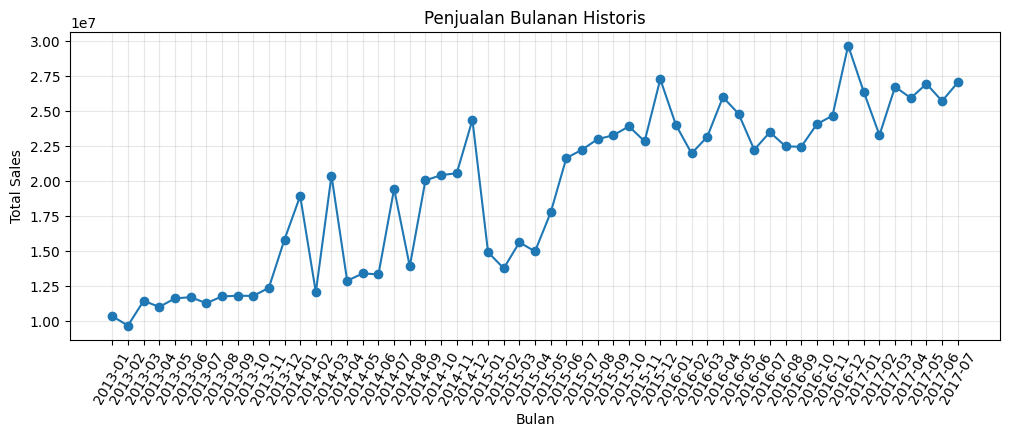

In [39]:
plt.figure(figsize=(12,4))
plt.plot(monthly_sales["month"], monthly_sales["sales"], marker="o")
plt.xticks(rotation=60)
plt.title("Penjualan Bulanan Historis")
plt.xlabel("Bulan")
plt.ylabel("Total Sales")
plt.grid(alpha=0.3)
plt.show()


In [40]:
# Tentukan jumlah kelas (discrete class seperti contoh soal)
k = 10   # boleh kamu tulis di laporan "dibagi menjadi 10 kelas"

monthly_sales["class"] = pd.cut(monthly_sales["sales"], bins=k)

monthly_sales.head()


,month,sales,class
0,2013-01,"10,327,624.7369","(9638978.45, 11657092.558]"
1,2013-02,"9,658,959.7774","(9638978.45, 11657092.558]"
2,2013-03,"11,428,497.0375","(9638978.45, 11657092.558]"
3,2013-04,"10,993,464.7380","(9638978.45, 11657092.558]"
4,2013-05,"11,597,704.0070","(9638978.45, 11657092.558]"


In [41]:
freq = monthly_sales["class"].value_counts().sort_index()
prob = freq / freq.sum()
cum_prob = prob.cumsum()

prob_table = pd.DataFrame({
    "Kelas Penjualan": freq.index,
    "Frekuensi (fi)": freq.values,
    "Probabilitas (pi)": prob.values,
    "Prob Kumulatif": cum_prob.values
})

# Bulatkan angka supaya cantik di laporan
prob_table["Probabilitas (pi)"] = prob_table["Probabilitas (pi)"].round(4)
prob_table["Prob Kumulatif"] = prob_table["Prob Kumulatif"].round(4)

prob_table


,Kelas Penjualan,Frekuensi (fi),Probabilitas (pi),Prob Kumulatif
0,"(9638978.45, 11657092.558]",6,0.1091,0.1091
1,"(11657092.558, 13655225.338]",9,0.1636,0.2727
2,"(13655225.338, 15653358.118]",5,0.0909,0.3636
3,"(15653358.118, 17651490.898]",1,0.0182,0.3818
4,"(17651490.898, 19649623.678]",3,0.0545,0.4364
5,"(19649623.678, 21647756.459]",5,0.0909,0.5273
6,"(21647756.459, 23645889.239]",11,0.2000,0.7273
7,"(23645889.239, 25644022.019]",6,0.1091,0.8364
8,"(25644022.019, 27642154.799]",8,0.1455,0.9818
9,"(27642154.799, 29640287.579]",1,0.0182,1.0000


In [42]:
# Bangun batas bawah–atas interval RN dari Prob Kumulatif
low = [0] + list(cum_prob.values[:-1])
high = list(cum_prob.values)

interval_table = prob_table.copy()
interval_table["Interval RN Low"] = np.round(low, 4)
interval_table["Interval RN High"] = np.round(high, 4)

interval_table


,Kelas Penjualan,Frekuensi (fi),Probabilitas (pi),Prob Kumulatif,Interval RN Low,Interval RN High
0,"(9638978.45, 11657092.558]",6,0.1091,0.1091,0.0000,0.1091
1,"(11657092.558, 13655225.338]",9,0.1636,0.2727,0.1091,0.2727
2,"(13655225.338, 15653358.118]",5,0.0909,0.3636,0.2727,0.3636
3,"(15653358.118, 17651490.898]",1,0.0182,0.3818,0.3636,0.3818
4,"(17651490.898, 19649623.678]",3,0.0545,0.4364,0.3818,0.4364
5,"(19649623.678, 21647756.459]",5,0.0909,0.5273,0.4364,0.5273
6,"(21647756.459, 23645889.239]",11,0.2000,0.7273,0.5273,0.7273
7,"(23645889.239, 25644022.019]",6,0.1091,0.8364,0.7273,0.8364
8,"(25644022.019, 27642154.799]",8,0.1455,0.9818,0.8364,0.9818
9,"(27642154.799, 29640287.579]",1,0.0182,1.0000,0.9818,1.0000


In [43]:
# Hitung midpoint dari setiap kelas interval
midpoints = []
for cls in interval_table["Kelas Penjualan"]:
    # cls adalah objek pandas.Interval
    mid = (cls.left + cls.right) / 2
    midpoints.append(mid)

interval_table["Midpoint Sales"] = np.round(midpoints, 2)

interval_table


,Kelas Penjualan,Frekuensi (fi),Probabilitas (pi),Prob Kumulatif,Interval RN Low,Interval RN High,Midpoint Sales
0,"(9638978.45, 11657092.558]",6,0.1091,0.1091,0.0000,0.1091,"10,648,035.5000"
1,"(11657092.558, 13655225.338]",9,0.1636,0.2727,0.1091,0.2727,"12,656,158.9500"
2,"(13655225.338, 15653358.118]",5,0.0909,0.3636,0.2727,0.3636,"14,654,291.7300"
3,"(15653358.118, 17651490.898]",1,0.0182,0.3818,0.3636,0.3818,"16,652,424.5100"
4,"(17651490.898, 19649623.678]",3,0.0545,0.4364,0.3818,0.4364,"18,650,557.2900"
5,"(19649623.678, 21647756.459]",5,0.0909,0.5273,0.4364,0.5273,"20,648,690.0700"
6,"(21647756.459, 23645889.239]",11,0.2000,0.7273,0.5273,0.7273,"22,646,822.8500"
7,"(23645889.239, 25644022.019]",6,0.1091,0.8364,0.7273,0.8364,"24,644,955.6300"
8,"(25644022.019, 27642154.799]",8,0.1455,0.9818,0.8364,0.9818,"26,643,088.4100"
9,"(27642154.799, 29640287.579]",1,0.0182,1.0000,0.9818,1.0000,"28,641,221.1900"


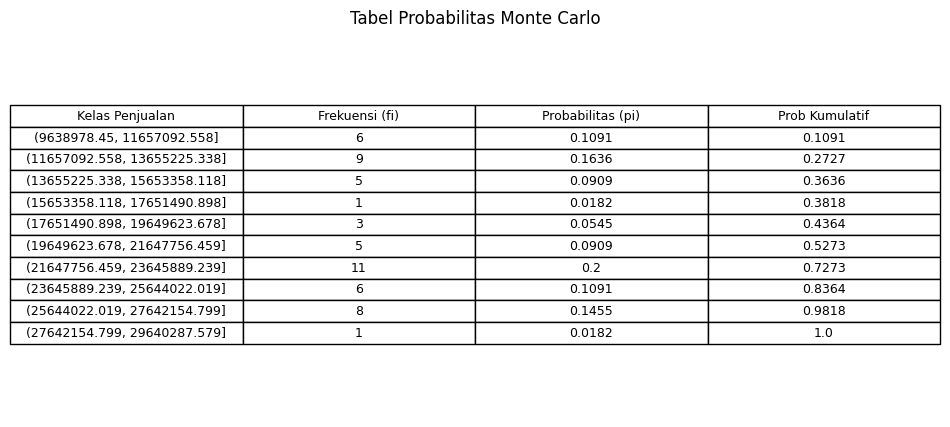

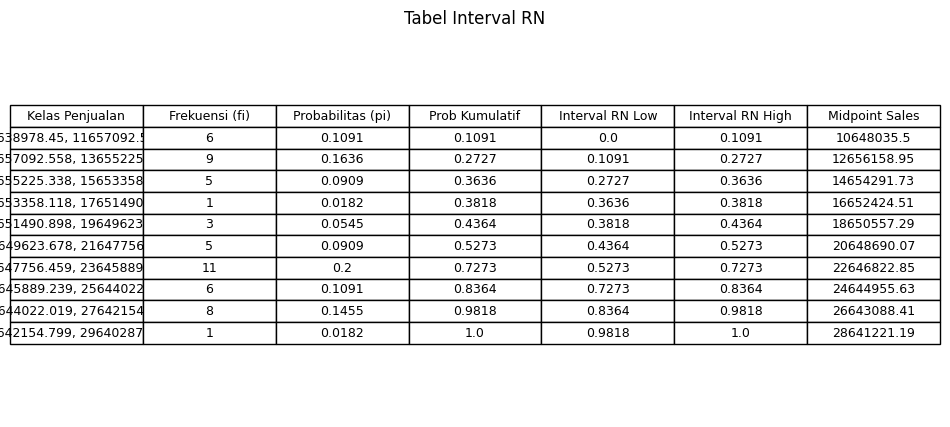

In [44]:
def save_table_as_image(df, filename, title):
    fig, ax = plt.subplots(figsize=(12, 2 + 0.3*len(df)))
    ax.axis("off")
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc="center",
        loc="center"
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.3)
    plt.title(title)
    plt.savefig(filename, bbox_inches="tight", dpi=200)
    plt.show()

save_table_as_image(prob_table, "prob_table.png", "Tabel Probabilitas Monte Carlo")
save_table_as_image(interval_table, "interval_table.png", "Tabel Interval RN")


In [45]:
def monte_carlo_predict(n_sim=2000, seed=42):
    """
    Monte Carlo dengan:
    - bilangan acak uniform 0–1
    - mapping ke interval RN
    - output = midpoint kelas penjualan
    """
    np.random.seed(seed)
    rands = np.random.rand(n_sim)

    sim_sales = []

    for r in rands:
        row = interval_table[
            (interval_table["Interval RN Low"] <= r) &
            (r < interval_table["Interval RN High"])
        ].iloc[0]
        sim_sales.append(row["Midpoint Sales"])

    sim_sales = np.array(sim_sales)
    pred_mean = sim_sales.mean()
    pred_std = sim_sales.std()

    return pred_mean, pred_std, sim_sales, rands

pred_mean, pred_std, sim_sales, rands = monte_carlo_predict(n_sim=2000)

pred_mean, pred_std


(np.float64(19347730.792885), np.float64(5758805.519984948))

In [46]:
result_summary = pd.DataFrame({
    "Jumlah Simulasi": [len(sim_sales)],
    "Prediksi Mean Sales Bulan Depan": [pred_mean],
    "Std Dev Simulasi": [pred_std],
    "Min Simulasi": [sim_sales.min()],
    "Max Simulasi": [sim_sales.max()]
})

result_summary.round(2)


,Jumlah Simulasi,Prediksi Mean Sales Bulan Depan,Std Dev Simulasi,Min Simulasi,Max Simulasi
0,2000,"19,347,730.7900","5,758,805.5200","10,648,035.5000","28,641,221.1900"


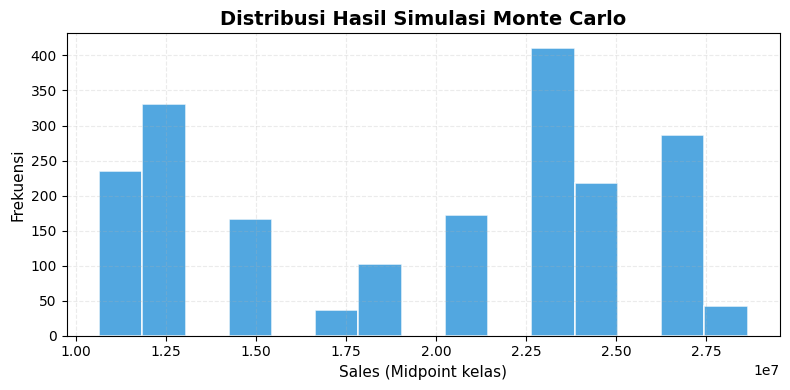

In [51]:
plt.figure(figsize=(8,4))

plt.hist(
    sim_sales,
    bins=15,
    edgecolor="white",
    linewidth=1.2,
    color="#3498db",      # biru
    alpha=0.85
)

plt.title("Distribusi Hasil Simulasi Monte Carlo", fontsize=14, fontweight="bold")
plt.xlabel("Sales (Midpoint kelas)", fontsize=11)
plt.ylabel("Frekuensi", fontsize=11)

plt.grid(alpha=0.25, linestyle="--")
plt.tight_layout()
plt.show()


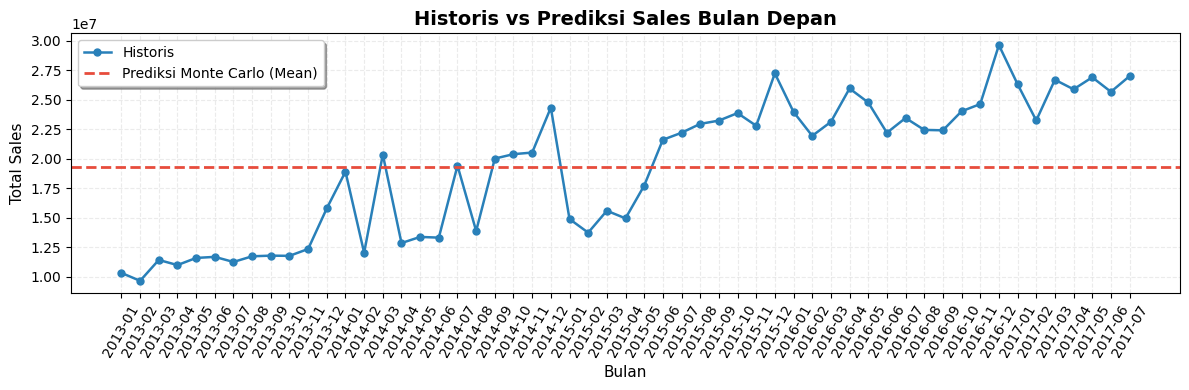

In [52]:
plt.figure(figsize=(12,4))

# garis historis
plt.plot(
    monthly_sales["month"],
    monthly_sales["sales"],
    marker="o",
    linestyle="-",
    linewidth=1.8,
    markersize=5,
    color="#2980b9",
    label="Historis"
)

# garis prediksi
plt.axhline(
    pred_mean,
    linestyle="--",
    linewidth=2,
    color="#e74c3c",
    label="Prediksi Monte Carlo (Mean)"
)

plt.xticks(rotation=60)
plt.title("Historis vs Prediksi Sales Bulan Depan", fontsize=14, fontweight="bold")
plt.xlabel("Bulan", fontsize=11)
plt.ylabel("Total Sales", fontsize=11)

plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(alpha=0.25, linestyle="--")
plt.tight_layout()
plt.show()
